In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import TensorDataset, DataLoader
from torchviz import make_dot
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

from sklearn import svm
from sklearn.model_selection import train_test_split

import glob
import os
import time
import sys
import wandb

sys.path.append("/home/cygnus/FUGIN_CAE_projects/FUGIN_CAE/120_layers/FUGIN_cloud")
from models import model_layer9_BatchNorm as model

In [2]:
import os
print(os.getcwd())

/home/cygnus/FUGIN_CAE_projects/FUGIN_CAE/120_layers/check_model


In [3]:
class DataSet():
    def __init__(self, data, label):
        self.label = label
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.label[index]

In [4]:
api = wandb.Api()
artifact_path = 'yudai22-/change_max/model_checkpoint:v56'
artifact = api.artifact(artifact_path)
artifact_dir = artifact.download()

print("Downloaded to:", artifact_dir)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Downloading large artifact model_checkpoint:v56, 67.63MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4


Downloaded to: /home/cygnus/FUGIN_CAE_projects/FUGIN_CAE/120_layers/check_model/artifacts/model_checkpoint:v56


In [5]:
run = artifact.logged_by()
latent = run.config["latent_num"]
print(latent)

weight_path = f"{artifact_dir}/model_parameter.pth"
weight_para = torch.load(weight_path, map_location=torch.device('cpu'))

100


In [6]:
model = model.Conv3dAutoencoder(latent)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

In [7]:
model.load_state_dict(weight_para)
model.to("cpu")
model.eval()

Conv3dAutoencoder(
  (encoder): Sequential(
    (0): Conv3d(1, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(32, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (7): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (10): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (13): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [8]:
summary(model.to(device), (1, 30, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 15, 50, 50]           2,080
       BatchNorm3d-2       [-1, 32, 15, 50, 50]              64
              ReLU-3       [-1, 32, 15, 50, 50]               0
            Conv3d-4        [-1, 32, 7, 25, 25]          65,568
       BatchNorm3d-5        [-1, 32, 7, 25, 25]              64
              ReLU-6        [-1, 32, 7, 25, 25]               0
            Conv3d-7        [-1, 64, 7, 25, 25]          55,360
       BatchNorm3d-8        [-1, 64, 7, 25, 25]             128
              ReLU-9        [-1, 64, 7, 25, 25]               0
           Conv3d-10        [-1, 64, 7, 25, 25]         110,656
      BatchNorm3d-11        [-1, 64, 7, 25, 25]             128
             ReLU-12        [-1, 64, 7, 25, 25]               0
           Conv3d-13        [-1, 32, 5, 23, 23]          55,328
      BatchNorm3d-14        [-1, 32, 5,

In [9]:
data = np.load("/home/cygnus/FUGIN_CAE_projects/FUGIN_CAE/120_layers/data/make_data/CygnusX_cut_change_max_resize_bubble_to_100x100.npy")
# data = np.load("/home/cygnus/FUGIN_CAE_projects/FUGIN_CAE/120_layers/data/cygnusX_layer120_merged_data_flip.npy")
print(len(data))
data = torch.from_numpy(data).float()
# data = data[:, None, :, :, :]
label = [0]*len(data)

# train_data, val_data, train_labels, val_labels = train_test_split(data, label, test_size=0.2, random_state=42, stratify=label)
# val_data, test_data, val_labels, test_labels = train_test_split(val_data, val_labels, test_size=0.25, random_state=42, stratify=val_labels)
# train_dataset = DataSet(train_data, train_labels)
# train_dataloader = DataLoader(train_dataset, batch_size=args.train_mini_batch, shuffle=True)
# val_dataset = DataSet(val_data, val_labels)
# val_dataloader = DataLoader(val_dataset, batch_size=args.val_mini_batch, shuffle=False)
test_dataset = DataSet(data, label)
test_dataloader = DataLoader(test_dataset, batch_size=33, shuffle=False)

33


In [10]:
print(test_dataset[0][0].shape)

torch.Size([30, 100, 100])


In [11]:
model.to("cpu")


output_list = []
for images, labels in test_dataloader:
    images = images.view(-1, 1, 30, 100, 100)  # バッチサイズを維持したままチャンネル数を1に設定
    with torch.set_grad_enabled(True):
            
        # モデルの出力を計算する
        output = model(images.clone().to("cpu"))
        output = output.squeeze()
        output_list.append(output.to("cpu").detach().numpy().copy())

In [12]:
output_list = np.concatenate(output_list)

In [13]:
print(len(output_list))
print(len(data))

33
33


In [14]:
num_index = np.random.choice(len(output_list[0]), 5)
num_index = list(num_index)
num_index.sort()
print(num_index)

[1, 12, 13, 18, 22]


In [15]:
# num_index = [10, 596, 798, 883, 1913]

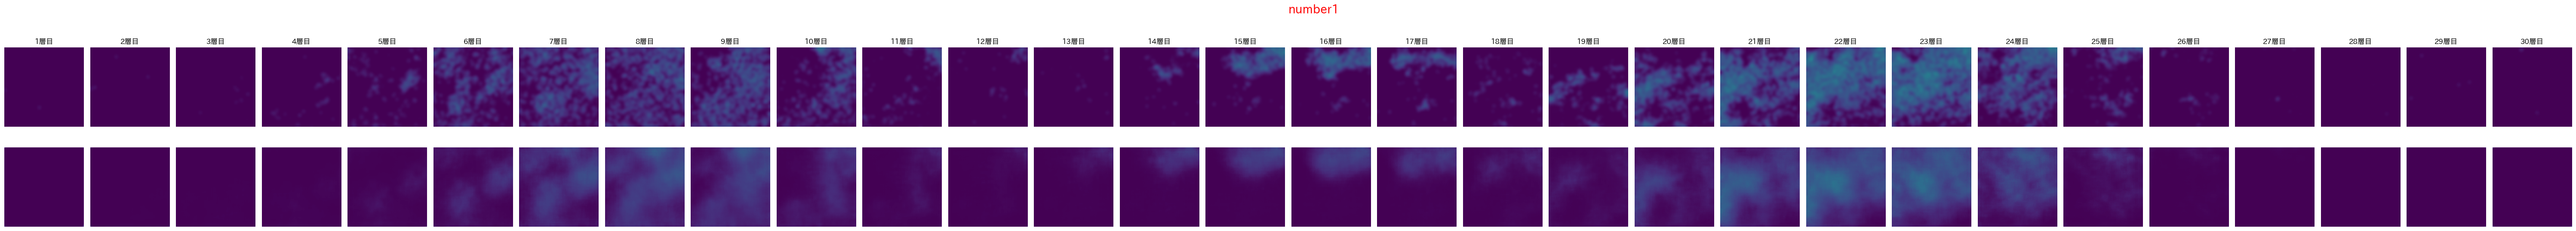

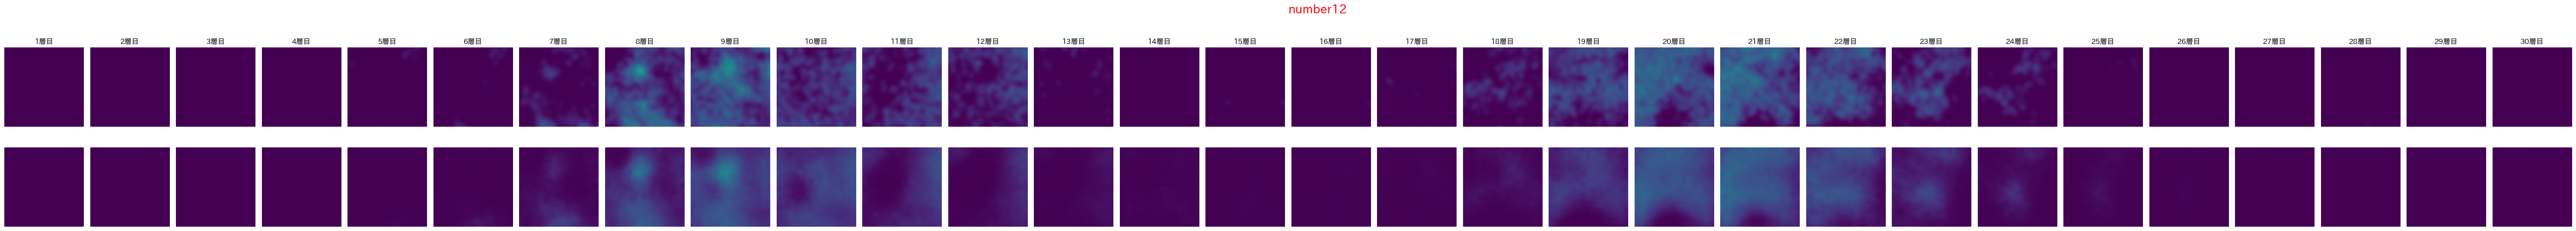

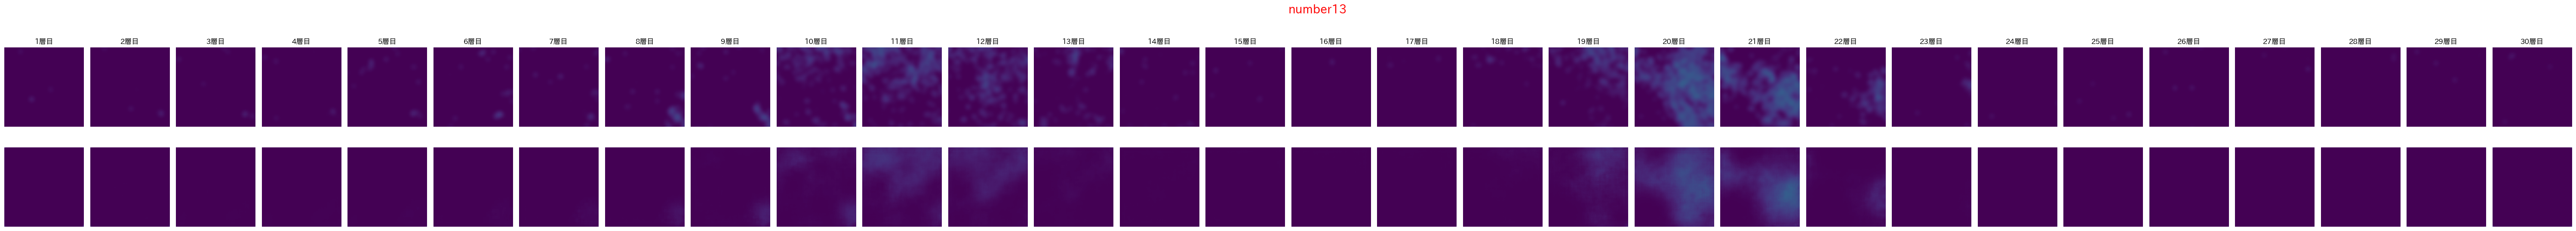

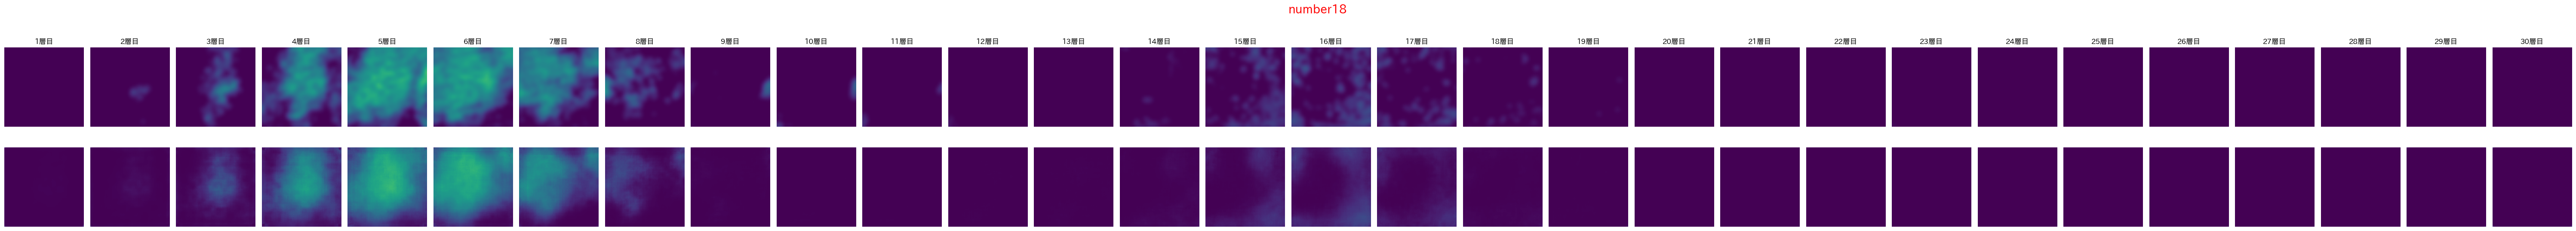

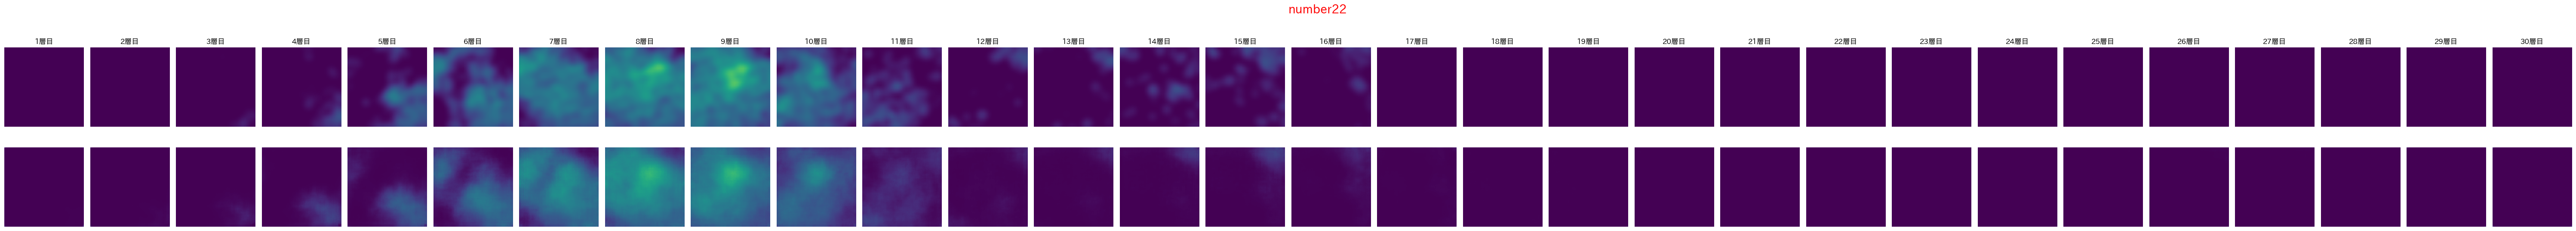

In [16]:
for i in num_index:
    image1 = data[i]
    image2 = output_list[i]

    fig, axes = plt.subplots(2, 30, figsize=(2*30, 6))
    for j in range(len(image1)):
        axes[0, j].imshow(image1[j, :, :], vmin=0, vmax=1)
        axes[0, j].axis('off')
        axes[0, j].set_title(f"{j+1}層目")
    
        axes[1, j].imshow(image2[j, :, :], vmin=0, vmax=1)
        axes[1, j].axis('off')

    fig.suptitle(f"number{i}", x=0.5, y=0.98, ha='left', fontsize=20, color="r")
    plt.tight_layout()
    # plt.savefig(f"/home/cygnus/Downloads/CygnusX/CAE/検証/CygnusX_latent{latent}_出力結果{i}.png", format="png")
    plt.show()

In [18]:
import re

match = re.findall('/.*/', artifact_path)
# log_name = re.search(r"(.*)", artifact_path).group()
log_name = artifact_path.split("/")[-1]

print(log_name)
print(match[0][1:-1])

model_checkpoint:v56
change_max


In [19]:
latent_save_dir = f"/home/cygnus/FUGIN_CAE_projects/FUGIN_CAE/120_layers/check_latent/latent_list/{match[0][1:-1]}"
print(latent_save_dir)

if os.path.exists(latent_save_dir):
    pass
else:
    os.makedirs(latent_save_dir)

/home/cygnus/FUGIN_CAE_projects/FUGIN_CAE/120_layers/check_latent/latent_list/change_max


In [21]:
# CAEのエンコーダ部分から潜在変数を抽出する
latent_list = []
for images, labels in test_dataloader:
    # 画像をモデルに入力するために正しいデバイスに移す
    images = images.view(-1, 1, 30, 100, 100)
    images = images.to("cpu")

    with torch.no_grad():  # 勾配計算は不要
        # エンコーダ部分のみの出力を取得（潜在変数）
        latent_output = model.encoder(images)

        # 潜在変数をリストに追加 (CPUに戻し、numpy形式に変換)
        latent_list.append(latent_output.cpu().detach().numpy())

# 潜在変数のリストを1つの配列に結合
latent_array = np.concatenate(latent_list, axis=0)
np.save(f"{latent_save_dir}/{log_name}_bubble_latent.npy", latent_array)

In [22]:
latent_array.shape

(33, 100)